In [1]:
import numpy as np
import pandas as pd
import re
import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

skf = KFold(n_splits=3, shuffle=True, random_state=24)

plt.rcParams['figure.figsize'] = (5, 3)
plt.rcParams['image.cmap'] = 'crest'
sns.color_palette("crest", as_cmap=True)
plt.style.use('ggplot')

In [11]:
data = pd.read_csv('real_estate_row.csv')
#data2 = pd.read_csv('real_estate_row_2.csv')
#data = pd.concat([data, data2], axis=0, ignore_index=True)
data.shape

(7948, 15)

In [12]:
data.head()

,id,price,currency,rooms,footage,floor,features,adress,district,subway,class,residential,description,detail,attributes
0,10825753,3 500,$/міс,4,135 / 100 / 25 м²,поверх 14 з 17,"['Суміжно-роздільна', 'Дизайнерський ремонт', ...",Драгомирова вул.,Печерський р-н,Дружби народів,ПРЕМІУМ,ЖК Новопечерські Липки,"Аренда 4к квартиры, Драгомирова, Печерск, Нов...",В квартирі 4 кімнати. Планування кімнат суміжн...,"['Лічильники', 'Супутникове ТБ', 'Кондиціонер'..."
1,10784117,599,$/міс,3,100 / 80 / 10 м²,поверх 6 з 6,"['Сталінка', 'Роздільне', 'Євроремонт']",Шовковична вул.,Печерський р-н,Хрещатик,ПРЕМІУМ,Офіс Президента,Дана квартира двоповерхова( два рівні) 4 кімна...,Два рівні,"['Лічильники', 'Кондиціонер', 'Пральна машина'..."
2,10715026,1 500,$/міс,3,110 / 70 / 18 м²,поверх 4 з 18,"['Українська цегла', 'Суміжно-роздільна', 'Диз...",Лютеранська вул.,Печерський р-н,Хрещатик,ПРЕМІУМ,Липки,ЖК Тріумфальна арка\nвул. Лютеранська 10А\n110...,"Відеоспостереження, консьєрж-сервіс, підземний...","['Посудомийна машина', 'Душова кабіна', 'Джаку..."
3,10810186,8 499,грн/міс,1,37 / 19 / 8 м²,поверх 19 з 24,"['Роздільне', 'Євроремонт', 'сьогодні']",Доковська вул.,Святошинський р-н,Коцюбинське,ПРЕМІУМ,ЖК Атлант (Коцюбинське),Квартира від власника! Без комісії! Знаходитьс...,В квартирі 1 кімната. Планування кімнат розділ...,[]
4,10824293,10 500,грн/міс,1,36 / 15 / 12 м²,поверх 18 з 25,"['Бетонно монолітний', 'Роздільне', 'Євроремонт']",Каховська вул.,Дніпровський р-н,Лівобережна,ПРЕМІУМ,ЖК Каховська,Левобережная. Каховская 56.Однокомнатная кварт...,"Будинок - бетонно монолітний, в квартирі 1 кім...",[]


In [13]:
data.shape

(7948, 15)

There are information about 7948 apartments in our dataset.

In [284]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7948 entries, 0 to 7948
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7948 non-null   int64 
 1   price        7948 non-null   object
 2   currency     7948 non-null   object
 3   rooms        7948 non-null   object
 4   footage      7948 non-null   object
 5   floor        7948 non-null   object
 6   features     7948 non-null   object
 7   adress       7948 non-null   object
 8   district     7948 non-null   object
 9   subway       7754 non-null   object
 10  class        5968 non-null   object
 11  residential  7436 non-null   object
 12  description  7948 non-null   object
 13  detail       7948 non-null   object
 14  attributes   7948 non-null   object
dtypes: int64(1), object(14)
memory usage: 993.5+ KB


All columns except of 'id' content 'object' type, so we need to convert it to number (price, number of rooms, floor).

### `price `

In [14]:
data['price'] = data['price'].map(lambda x: int(x.replace(' ', '').strip()))

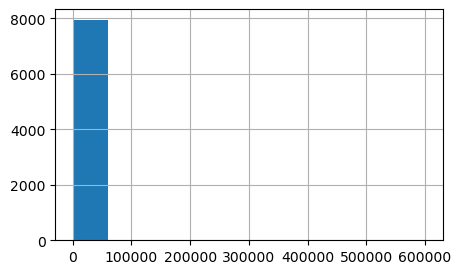

In [286]:
data['price'].hist();

In [287]:
data['price'].describe()

count      7948.000000
mean      11015.826749
std       12778.002467
min         250.000000
25%        4996.000000
50%       10000.000000
75%       15000.000000
max      600000.000000
Name: price, dtype: float64

The most of apartments' price up to 40000, but we have two different type of currency, so we need convert all price to one currency, for example 'hrn'. We will use the exchange rate for the date of receiving the dataset (38.0)

In [288]:
data['currency'].value_counts(dropna=False)

грн/міс    6014
$/міс      1934
Name: currency, dtype: int64

In [16]:
data[(data['currency'] == '$/міс')].sort_values('price', axis=0, ascending=False).head(10)

,id,price,currency,rooms,footage,floor,features,adress,district,subway,class,residential,description,detail,attributes
7062,10830532,518000,$/міс,4,185 / 160 / 20 м²,поверх 20 з 24,"['Суміжно-роздільна', 'Дизайнерський ремонт', ...",Драгомирова вул.,Печерський р-н,Дружби народів,Дружби народів,ЖК Новопечерські Липки,Аренда 4-комнатной квартиры в жилом комплексе ...,В квартирі 4 кімнати. Планування кімнат суміжн...,[]
186,10824175,252000,$/міс,4,120 / 70 / 15 м²,поверх 13 з 21,"['Бетонно монолітний', 'Роздільне', 'Дизайнерс...",Буслівська вул.,Печерський р-н,Видубичі,ПРЕМІУМ,ЖК Busov Hill,Оренда 4к 120 кв м в ЖК Busov Hill. Новий ремо...,"Будинок - бетонно монолітний, в квартирі 4 кім...","['Посудомийна машина', 'Кондиціонер', 'Посуд',..."
6192,10831306,52800,$/міс,3,88 / 65 / 23 м²,поверх 11 з 24,"['Дизайнерський ремонт', 'сьогодні', 'сьогодні']",Вишгородська вул.,Подільський р-н,Вишгородський масив,NaN,ЖК Паркове місто,Предлагается в аренду 3-х комнатная квартира в...,В квартирі 3 кімнати. Загальний стан квартири ...,[]
7409,10829460,40000,$/міс,2,40 / 18 / 12 м²,поверх 14 з 26,"['Бетонно монолітний', 'Студія', 'Дизайнерськи...",Оболонський просп.,Оболонський р-н,Мінська,Мінська,ТРЦ DREAM yellow,Сдается Евро-двушка - по документам 1к квартир...,"Будинок - бетонно монолітний, в квартирі 2 кім...",[]
5675,10831726,37200,$/міс,2,62 / 40 / 20 м²,поверх 5 з 5,"['Хороший стан', 'сьогодні', 'сьогодні']",Чигоріна вул.,Печерський р-н,Дружби народів,ПРЕМІУМ,ТЦ Ocean Plaza,"Вул. Чигоріна, 55\nКвартира площею 62 кВ.м зна...",В квартирі 2 кімнати. Загальний стан квартири ...,[]
3186,10822406,33000,$/міс,3,110 / 85 / 18 м²,поверх 4 з 14,"['Українська цегла', 'Суміжно-роздільна', 'Чуд...",Златоустівська вул.,Шевченківський р-н,Лук'янівська,БЕЗ КОМІСІЇ,Юрковиця,В оренду пропонуєтсья простора та затишна 3-кі...,"Будинок - українська цегла, в квартирі 3 кімна...",[]
330,10458331,15000,$/міс,5,350 / 94 / 43 м²,поверх 5 з 5,"['Роздільне', 'Дизайнерський ремонт', 'вчора']",Ломаківська вул. (Мічуріна),Печерський р-н,Батьківщина-Мати,ПРЕМІУМ,Пам'ятник засновникам Києва,Добро пожаловать в роскошные апартаменты в клу...,В квартирі 5 кімнат. Планування кімнат розділь...,"['Джакузі', 'Сигналізація', 'Кондиціонер', 'Мі..."
4301,10640634,15000,$/міс,2,350 / 100 / 150 м²,поверх 5 з 7,"['Дизайнерський ремонт', '1 тиж. тому', '5 міс...",Болсуновський пров. (Мічуріна),Печерський р-н,Батьківщина-Мати,БЕЗ КОМІСІЇ,Пам'ятник засновникам Києва,Такого Вы не видели. Обращайтесь) [ссылка скрыта],В квартирі 2 кімнати. Загальний стан квартири ...,[]
5882,10830459,10000,$/міс,5,240 / 160 / 30 м²,поверх 9 з 17,"['Роздільне', 'Дизайнерський ремонт', 'вчора']",Драгомирова вул.,Печерський р-н,Дружби народів,ПРЕМІУМ,ЖК Новопечерські Липки,Предлагаются в аренду Новые дизайнерские 5-ком...,В квартирі 5 кімнат. Планування кімнат розділь...,"['Посудомийна машина', 'Душова кабіна', 'Лічил..."
4413,10657968,10000,$/міс,6,364 / 170 / 25 м²,поверх 8 з 21,"['Суміжно-роздільна', 'Перша здача', '2 тиж. т...",Мазепи Івана вул. (Січневого Повстання),Печерський р-н,Дніпро,БЕЗ КОМІСІЇ,ЖК Diamond Hill,Видовые апартаменты представительского класса ...,Территория жилого комплекса находится под конт...,[]


It's look like the first six apartments have mistake in currency, so we change it to 'грн/міс'. 

In [15]:
idx = data[(data['currency'] == '$/міс')].sort_values('price', axis=0, ascending=False).head(6).index
idx

Int64Index([7062, 186, 6192, 7409, 5675, 3186], dtype='int64')

In [17]:
data.loc[idx, 'currency'] = 'грн/міс'

In [18]:
data[(data['currency'] == '$/міс')].sort_values('price', axis=0, ascending=False).head()

,id,price,currency,rooms,footage,floor,features,adress,district,subway,class,residential,description,detail,attributes
4301,10640634,15000,$/міс,2,350 / 100 / 150 м²,поверх 5 з 7,"['Дизайнерський ремонт', '1 тиж. тому', '5 міс...",Болсуновський пров. (Мічуріна),Печерський р-н,Батьківщина-Мати,БЕЗ КОМІСІЇ,Пам'ятник засновникам Києва,Такого Вы не видели. Обращайтесь) [ссылка скрыта],В квартирі 2 кімнати. Загальний стан квартири ...,[]
330,10458331,15000,$/міс,5,350 / 94 / 43 м²,поверх 5 з 5,"['Роздільне', 'Дизайнерський ремонт', 'вчора']",Ломаківська вул. (Мічуріна),Печерський р-н,Батьківщина-Мати,ПРЕМІУМ,Пам'ятник засновникам Києва,Добро пожаловать в роскошные апартаменты в клу...,В квартирі 5 кімнат. Планування кімнат розділь...,"['Джакузі', 'Сигналізація', 'Кондиціонер', 'Мі..."
4413,10657968,10000,$/міс,6,364 / 170 / 25 м²,поверх 8 з 21,"['Суміжно-роздільна', 'Перша здача', '2 тиж. т...",Мазепи Івана вул. (Січневого Повстання),Печерський р-н,Дніпро,БЕЗ КОМІСІЇ,ЖК Diamond Hill,Видовые апартаменты представительского класса ...,Территория жилого комплекса находится под конт...,[]
2739,10807023,10000,$/міс,6,368 / 200 / 35 м²,поверх 15 з 20,"['Роздільне', 'Перша здача', '1 день тому']",Мазепи Івана вул. (Січневого Повстання),Печерський р-н,Дніпро,БЕЗ КОМІСІЇ,Печерськ,Опис\nЭксклюзивные апартаменты в ЖК «Diamond H...,В квартирі 6 кімнат. Планування кімнат розділь...,[]
5882,10830459,10000,$/міс,5,240 / 160 / 30 м²,поверх 9 з 17,"['Роздільне', 'Дизайнерський ремонт', 'вчора']",Драгомирова вул.,Печерський р-н,Дружби народів,ПРЕМІУМ,ЖК Новопечерські Липки,Предлагаются в аренду Новые дизайнерские 5-ком...,В квартирі 5 кімнат. Планування кімнат розділь...,"['Посудомийна машина', 'Душова кабіна', 'Лічил..."


In [19]:
def get_price(row):
    if row['currency'] == '$/міс':
        return row['price'] * 38        
    return row['price']
    
data['price'] = data.apply(get_price, axis=1)

In [20]:
data['price'].describe()

count      7948.000000
mean      23899.289129
std       30091.790185
min        2000.000000
25%        9900.000000
50%       15000.000000
75%       27000.000000
max      600000.000000
Name: price, dtype: float64

In [21]:
data[data.price == data.price.max()]

,id,price,currency,rooms,footage,floor,features,adress,district,subway,class,residential,description,detail,attributes
7802,10820150,600000,грн/міс,3,700 / 89 / 87 м²,поверх 9 з 11,"['Задовільний стан', 'вчора', '1 тиж. тому']",Арсенальна пл.,Печерський р-н,Арсенальна,Арсенальна,Маріїнський парк,Тут ви можете дати волю фантазії і описати об’...,В квартирі 3 кімнати. Загальний стан квартири ...,[]


In [22]:
data[data.price > np.percentile(data.price, 99)]

,id,price,currency,rooms,footage,floor,features,adress,district,subway,class,residential,description,detail,attributes
48,10729782,342000,$/міс,5,221 / 140 / 15 м²,поверх 3 з 5,"['Роздільне', 'Дизайнерський ремонт', '3 тиж. ...",Володимирська вул.,Шевченківський р-н,Майдан Незалежності,БЕЗ КОМІСІЇ,Пейзажна алея,Апартаменти представницького класу в преміальн...,В квартирі 5 кімнат. Планування кімнат розділь...,[]
56,10823138,178600,$/міс,4,130 / 52 / 36 м²,поверх 14 з 30,"['Роздільне', 'Чудовий стан', 'сьогодні']",Драгомирова вул.,Печерський р-н,Дружби народів,ПРЕМІУМ,ЖК Новопечерські Липки,"Предлагается в аренду новая квартира в ЖК ""Нов...",В квартирі 4 кімнати. Планування кімнат розділ...,"['Душова кабіна', 'Лічильники', 'Сигналізація'..."
172,10826023,171000,$/міс,2,100 / 50 / 50 м²,поверх 23 з 23,"['Бетонно монолітний', 'Пентхаус', 'Дизайнерсь...",Лабораторний пров.,Печерський р-н,Олімпійська,ПРЕМІУМ,ЖК Alter Ego,Как только вы входите в этот пентхаус на 23-м ...,"Будинок - бетонно монолітний, в квартирі 2 кім...",[]
176,10215891,152000,$/міс,2,95 / 50 / 45 м²,поверх 24 з 24,"['Бетонно монолітний', 'Пентхаус', 'Євроремонт']",Лабораторний пров.,Печерський р-н,Олімпійська,ПРЕМІУМ,ЖК Alter Ego,Цельное пространство первого этажа разделено н...,"Будинок - бетонно монолітний, в квартирі 2 кім...","['Посудомийна машина', 'Душова кабіна', 'Джаку..."
186,10824175,252000,грн/міс,4,120 / 70 / 15 м²,поверх 13 з 21,"['Бетонно монолітний', 'Роздільне', 'Дизайнерс...",Буслівська вул.,Печерський р-н,Видубичі,ПРЕМІУМ,ЖК Busov Hill,Оренда 4к 120 кв м в ЖК Busov Hill. Новий ремо...,"Будинок - бетонно монолітний, в квартирі 4 кім...","['Посудомийна машина', 'Кондиціонер', 'Посуд',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7582,10507841,190000,$/міс,5,170 / 100 / 25 м²,поверх 15 з 24,"['Бетонно монолітний', 'Роздільне', 'Дизайнерс...",Деміївська вул.,Голосіївський р-н,Деміївська,БЕЗ КОМІСІЇ,ЖК Park Avenue VIP,Аренда эксклюзивной дизайнерской 5-ти комнатно...,"Будинок - бетонно монолітний, в квартирі 5 кім...",[]
7584,10716300,266000,$/міс,5,185 / 100 / 25 м²,поверх 7 з 30,"['Бетонно монолітний', 'Роздільне', 'Дизайнерс...",Драгомирова вул.,Печерський р-н,Печерська,Печерська,ЖК Новопечерські Липки,Видовая 5-комнатная квартира (185 кв.м.) в ЖК ...,"Будинок - бетонно монолітний, в квартирі 5 кім...",[]
7604,10442384,171000,$/міс,5,250 / 80 / 65 м²,поверх 4 з 5,"['Бетонно монолітний', 'Пентхаус', 'Чудовий ст...",Болсуновський пров. (Мічуріна),Печерський р-н,Печерська,БЕЗ КОМІСІЇ,ЖК Pechersk Hills Residence,"""Pechersk Hills Residence"" це сучасний житлови...","Будинок - бетонно монолітний, в квартирі 5 кім...",[]
7802,10820150,600000,грн/міс,3,700 / 89 / 87 м²,поверх 9 з 11,"['Задовільний стан', 'вчора', '1 тиж. тому']",Арсенальна пл.,Печерський р-н,Арсенальна,Арсенальна,Маріїнський парк,Тут ви можете дати волю фантазії і описати об’...,В квартирі 3 кімнати. Загальний стан квартири ...,[]


In [ ]:
data.drop(columns='currency', axis=1, inplace=True)

### `rooms`

In [23]:
data['rooms'].value_counts()

2         3154
1         2637
3         1632
4          386
5          109
6           26
Вільне       4
Name: rooms, dtype: int64

In [299]:
data[data['rooms'] == 'Вільне']

,id,price,currency,rooms,footage,floor,features,adress,district,subway,class,residential,description,detail,attributes
631,10398243,45000,грн/міс,Вільне,120 / 95 / 5 м²,поверх 2 з 5,"['Стара цегла', 'Роздільне', 'Хороший стан']",Велика Васильківська вул. (Червоноармійська),Печерський р-н,Олімпійська,Доступна на короткий термін,Черепанова гора,"Будинок - стара цегла, квартира вільного плану...","\nКиїв, Велика Васильківська вул. (Червоноармі...",[]
4818,10819168,16500,грн/міс,Вільне,50 / 40 / 10 м²,поверх 19 з 25,"['Студія', 'Євроремонт', '1 день тому']",Євгена Сверстюка вул. (Раскової Марини),Дніпровський р-н,Лівобережна,Лівобережна,ЖК Галактика,Здається світла і простора кваритра у жк «Гала...,Квартира вільного планування. Вид з вікон у дв...,[]
5549,10764600,38000,$/міс,Вільне,48.1 / 18.5 / 12.5 м²,поверх 4 з 7,"['Українська цегла', 'Чудовий стан', '1 тиж. т...",Дегтярна вул.,Подільський р-н,Контрактова площа,Контрактова площа,ЖК Подол Град,"Мінімалістична, світла, функціонально наповнен...","Будинок - українська цегла, квартира вільного ...",[]
7743,9836715,11500,грн/міс,Вільне,30 / 15 / 10 м²,поверх 4 з 25,"['Євроремонт', 'сьогодні', '2 р. 1 міс. тому']",Каховська вул.,Дніпровський р-н,Лівобережна,Лівобережна,NaN,Идеально для одного или пары\nЕсть все для ком...,Квартира вільного планування. Загальний стан к...,[]


Convert 'rooms' column to categorical type.

In [24]:
data['rooms'] = data['rooms'].astype('category')
data['rooms']

0       4
1       3
2       3
3       1
4       1
       ..
7943    1
7944    1
7945    2
7946    1
7947    2
Name: rooms, Length: 7948, dtype: category
Categories (7, object): ['1', '2', '3', '4', '5', '6', 'Вільне']

### `footage`
Convert column 'footage' into three features: 'full_area', 'living_area', 'kitchen_area'. 

In [159]:
s = '48.1 / 18.5 / 12.5 м²'

full_area, living_area, kitchen_area = re.findall(r'[\d\.]{2,}|\d+', s)
full_area, living_area, kitchen_area

('48.1', '18.5', '12.5')

In [27]:
number_pattern = re.compile(r'[\d\.]{2,}|\d+')
data['full_area'] = data['footage'].map(lambda x: float(re.findall(number_pattern, x)[0]))
data['living_area'] = data['footage'].map(lambda x: float(re.findall(number_pattern, x)[1]))
data['kitchen_area'] = data['footage'].map(lambda x: float(re.findall(number_pattern, x)[2]))

In [28]:
data[['full_area', 'living_area', 'kitchen_area']]

,full_area,living_area,kitchen_area
0,135.0,100.0,25.0
1,100.0,80.0,10.0
2,110.0,70.0,18.0
3,37.0,19.0,8.0
4,36.0,15.0,12.0
...,...,...,...
7943,50.0,20.0,15.0
7944,36.0,20.0,8.0
7945,32.0,16.0,7.0
7946,45.0,35.0,9.0


In [29]:
data.to_csv('real_estate_clean.csv', index=False)

### `floor`
Convert column 'floor' into two features: 'floor', 'num_storeys'. 

In [30]:
number_pattern = re.compile(r'[\d\.]{2,}|\d+')
data['num_storeys'] = data['floor'].map(lambda x: int(re.findall(number_pattern, x)[1]))
data['floor'] = data['floor'].map(lambda x: int(re.findall(number_pattern, x)[0]))

In [31]:
data[['floor', 'num_storeys']]

,floor,num_storeys
0,14,17
1,6,6
2,4,18
3,19,24
4,18,25
...,...,...
7943,9,25
7944,8,9
7945,3,9
7946,3,16


In [32]:
data.head()

,id,price,currency,rooms,footage,floor,features,adress,district,subway,class,residential,description,detail,attributes,full_area,living_area,kitchen_area,num_storeys
0,10825753,133000,$/міс,4,135 / 100 / 25 м²,14,"['Суміжно-роздільна', 'Дизайнерський ремонт', ...",Драгомирова вул.,Печерський р-н,Дружби народів,ПРЕМІУМ,ЖК Новопечерські Липки,"Аренда 4к квартиры, Драгомирова, Печерск, Нов...",В квартирі 4 кімнати. Планування кімнат суміжн...,"['Лічильники', 'Супутникове ТБ', 'Кондиціонер'...",135.0,100.0,25.0,17
1,10784117,22762,$/міс,3,100 / 80 / 10 м²,6,"['Сталінка', 'Роздільне', 'Євроремонт']",Шовковична вул.,Печерський р-н,Хрещатик,ПРЕМІУМ,Офіс Президента,Дана квартира двоповерхова( два рівні) 4 кімна...,Два рівні,"['Лічильники', 'Кондиціонер', 'Пральна машина'...",100.0,80.0,10.0,6
2,10715026,57000,$/міс,3,110 / 70 / 18 м²,4,"['Українська цегла', 'Суміжно-роздільна', 'Диз...",Лютеранська вул.,Печерський р-н,Хрещатик,ПРЕМІУМ,Липки,ЖК Тріумфальна арка\nвул. Лютеранська 10А\n110...,"Відеоспостереження, консьєрж-сервіс, підземний...","['Посудомийна машина', 'Душова кабіна', 'Джаку...",110.0,70.0,18.0,18
3,10810186,8499,грн/міс,1,37 / 19 / 8 м²,19,"['Роздільне', 'Євроремонт', 'сьогодні']",Доковська вул.,Святошинський р-н,Коцюбинське,ПРЕМІУМ,ЖК Атлант (Коцюбинське),Квартира від власника! Без комісії! Знаходитьс...,В квартирі 1 кімната. Планування кімнат розділ...,[],37.0,19.0,8.0,24
4,10824293,10500,грн/міс,1,36 / 15 / 12 м²,18,"['Бетонно монолітний', 'Роздільне', 'Євроремонт']",Каховська вул.,Дніпровський р-н,Лівобережна,ПРЕМІУМ,ЖК Каховська,Левобережная. Каховская 56.Однокомнатная кварт...,"Будинок - бетонно монолітний, в квартирі 1 кім...",[],36.0,15.0,12.0,25


### `features`
Extract all apartment characteristics from 'features'

In [33]:
data['features'].isna().sum()

0

In [35]:
data['features'].sample(3)

4896          ['Роздільне', 'Хороший стан', '2 дні тому']
2803    ['Українська цегла', 'Роздільне', 'Дизайнерськ...
6355    ['Українська цегла', 'Суміжно-роздільна', 'Євр...
Name: features, dtype: object

In [36]:
data['features'][5000]

"['Роздільне', 'Хороший стан', '2 дні тому']"

In [37]:
data['features'][5000].replace('[', '').replace(']', '').replace("'", '').split(',')

['Роздільне', ' Хороший стан', ' 2 дні тому']

In [41]:
all_characteristics = set()

def extract_characteristics(features):
    for value in features.replace('[', '').replace(']', '').replace("'", '').split(','):
        value = value.strip()
        if 'тому' in value: continue
        all_characteristics.add(value)

_ = data['features'].map(extract_characteristics)
all_characteristics

{'Євроремонт',
 'Багаторівнева',
 'Бетонно монолітний',
 'Від будівельників вільне планування',
 'Газоблок',
 'Дизайнерський ремонт',
 'Дореволюційний',
 'Задовільний стан',
 'Кухня-вітальня',
 'Незавершений ремонт',
 'Пентхаус',
 'Перша здача',
 'Потрібен капітальний ремонт',
 'Потрібен косметичний ремонт',
 'Роздільне',
 'Сталінка',
 'Стара панель',
 'Стара цегла',
 'Студія',
 'Суміжна',
 'Суміжно-роздільна',
 'Типова панель',
 'Українська панель',
 'Українська цегла',
 'Хороший стан',
 'Чудовий стан',
 'вчора',
 'сьогодні'}

In [92]:
dict_all_characteristics = {
    'Євроремонт': 'eurorenovation',
    'Багаторівнева': 'multilevel',
    'Бетонно монолітний': 'concrete_monolithic',
    'Від будівельників вільне планування': 'free_planning',
    'Газоблок': 'gas_block',
    'Дизайнерський ремонт': 'designer_renovation',
    'Дореволюційний': 'pre_revolutionary',
    'Задовільний стан': 'satisfactory_condition',
    'Кухня-вітальня': 'kitchen_living_room',
    'Незавершений ремонт': 'repair_in_progress',
    'Пентхаус': 'penthouse',
    'Перша здача': 'first_rental',
    'Потрібен капітальний ремонт': 'needs_major_repairs',
    'Потрібен косметичний ремонт': 'needs_cosmetic_repairs',
    'Роздільне': 'separate',
    'Сталінка': 'Stalinka',
    'Стара панель': 'old_panel',
    'Стара цегла': 'old_brick',
    'Студія': 'studio',
    'Суміжна': 'adjacent',
    'Суміжно-роздільна': 'adjacent_separate',
    'Типова панель': 'typical_panel',
    'Українська панель': 'ukrainian_panel',
    'Українська цегла': 'ukrainian_brick',
    'Хороший стан': 'good_condition',
    'Чудовий стан': 'excellent_condition',
}

In [46]:
all_characteristics -=  {'вчора', 'сьогодні'}
len(all_characteristics)

26

In [47]:
idx, labels = pd.factorize(list(all_characteristics))
idx, labels

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int64),
 array(['Типова панель', 'Бетонно монолітний', 'Стара цегла',
        'Перша здача', 'Суміжно-роздільна', 'Українська цегла',
        'Євроремонт', 'Задовільний стан', 'Багаторівнева',
        'Потрібен косметичний ремонт', 'Кухня-вітальня', 'Пентхаус',
        'Стара панель', 'Хороший стан', 'Дореволюційний',
        'Потрібен капітальний ремонт', 'Газоблок', 'Незавершений ремонт',
        'Від будівельників вільне планування', 'Суміжна', 'Роздільне',
        'Українська панель', 'Сталінка', 'Чудовий стан', 'Студія',
        'Дизайнерський ремонт'], dtype=object))

In [93]:
idx, labels = pd.factorize(list(all_characteristics))

for id_ in idx:
    charact_label = labels[id_]
    cat_name = dict_all_characteristics[charact_label]
    
    data[cat_name] = data['features'].map(lambda x: int(charact_label in x))

In [94]:
data.loc[125, 'features']

"['Українська цегла', 'Роздільне', 'Задовільний стан']"

In [95]:
data.iloc[125, -26:]

typical_panel             0
concrete_monolithic       0
old_brick                 0
first_rental              0
adjacent_separate         0
ukrainian_brick           1
eurorenovation            0
satisfactory_condition    1
multilevel                0
needs_cosmetic_repairs    0
kitchen_living_room       0
penthouse                 0
old_panel                 0
good_condition            0
pre_revolutionary         0
needs_major_repairs       0
gas_block                 0
repair_in_progress        0
free_planning             0
adjacent                  0
separate                  1
ukrainian_panel           0
Stalinka                  0
excellent_condition       0
studio                    0
designer_renovation       0
Name: 125, dtype: object

In [2]:
# data = pd.read_csv('real_estate_clean.csv')

In [53]:
data.sample(3)

,id,price,currency,rooms,footage,floor,features,adress,district,subway,...,Газоблок,Незавершений_ремонт,Від_будівельників_вільне_планування,Суміжна,Роздільне,Українська_панель,Сталінка,Чудовий_стан,Студія,Дизайнерський_ремонт
4008,10778397,16000,грн/міс,1,48 / 24 / 16 м²,7,"['Бетонно монолітний', 'Кухня-вітальня', 'Євро...",Соборності просп. (Возз'єднання),Дніпровський р-н,Проспект Соборності,...,0,0,0,0,0,0,0,0,0,0
5410,9560421,12000,грн/міс,2,74 / 50 / 12 м²,5,"['Українська цегла', 'Роздільне', 'Євроремонт']",Головка Андрія вул.,Солом'янський р-н,Олександрівська слобідка,...,0,0,0,0,1,0,0,0,0,0
3033,10825452,12990,грн/міс,2,63 / 32 / 12 м²,19,"['Роздільне', 'Євроремонт', '2 дні тому']",Софії Русової вул.,Дарницький р-н,Позняки,...,0,0,0,0,1,0,0,0,0,0


In [54]:
data['district'].value_counts(dropna=False)

Печерський р-н        1540
Дарницький р-н        1154
Шевченківський р-н    1131
Голосіївський р-н      949
Дніпровський р-н       773
Солом'янський р-н      669
Оболонський р-н        561
Святошинський р-н      432
Подільський р-н        372
Деснянський р-н        366
Київ                     1
Name: district, dtype: int64

In [103]:
data.to_csv('real_estate_clean.csv', index=False)

### `subway`

In [14]:
data = pd.read_csv('real_estate_clean.csv')

In [15]:
data

,id,price,rooms,floor,adress,district,subway,class,residential,description,...,dishwashers,alarms,bed,counters,air_conditioning,refrigerator,jacuzzi,microwave,iron,cable_TV
0,10825753,133000,4,14,"Драгомирова вул., 11",Печерський р-н,Дружби народів,ПРЕМІУМ,ЖК Новопечерські Липки,"Аренда 4к квартиры, Драгомирова, Печерск, Нов...",...,0,0,1,1,1,1,0,1,1,0
1,10784117,22762,3,6,Шовковична вул.,Печерський р-н,Хрещатик,ПРЕМІУМ,Офіс Президента,Дана квартира двоповерхова( два рівні) 4 кімна...,...,0,0,1,1,1,1,0,0,1,1
2,10715026,57000,3,4,Лютеранська вул.,Печерський р-н,Хрещатик,ПРЕМІУМ,Липки,ЖК Тріумфальна арка\nвул. Лютеранська 10А\n110...,...,1,0,1,1,1,1,1,1,1,1
3,10810186,8499,1,19,Доковська вул.,Святошинський р-н,no,ПРЕМІУМ,ЖК Атлант (Коцюбинське),Квартира від власника! Без комісії! Знаходитьс...,...,0,0,0,0,0,0,0,0,0,0
4,10824293,10500,1,18,Каховська вул.,Дніпровський р-н,Лівобережна,ПРЕМІУМ,ЖК Каховська,Левобережная. Каховская 56.Однокомнатная кварт...,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7943,10620878,16000,1,9,"Крамського Івана вул., 9",Святошинський р-н,Житомирська,Доступна на короткий термін,"ЖК Будинок на вул. Крамського, 9","м. Київ, вул. Крамського 9. Оренда 1но кім. ...",...,1,0,1,1,1,1,0,0,1,1
7944,10803998,9500,1,8,"Кіпріанова академіка вул., 6А",Святошинський р-н,no,NaN,Микільська Борщагівка,Здам 1-кімнатну квартиру по вул. Академіка Кіп...,...,0,0,0,1,0,1,0,0,1,0
7945,9615917,6000,2,3,"Данила Щербаківського вул. (Щербакова), 54",Шевченківський р-н,Святошин,Святошин,Нивки,На длительную аренду по ул Львовская в отличн...,...,0,0,0,1,0,1,0,0,0,0
7946,10055853,9000,1,3,"Стуса Василя вул., 28а",Святошинський р-н,NaN,NaN,NaN,"Просторная квартира, большая кухня, два балкон...",...,0,0,0,1,0,1,0,1,1,0


In [16]:
subway = {
    'академмістечко', 'арсенальна', 'берестейська', 'бориспільська', 
    'васильківська', 'видубичі', 'вирлиця', 'виставковий центр', 
    'вокзальна', 'героїв дніпра', 'гідропарк', 'голосіївська', 
    'дарниця', 'деміївська', 'дніпро', 'дорогожичі', 'дружби народів', 
    'житомирська', 'золоті ворота', 'іподром', 'кловська', 
    'контрактова площа', 'либідська', 'лівобережна', 'лісова', 
    'лук\'янівська', 'майдан незалежності', 'мінська', 'нивки', 
    'оболонь', 'олімпійська', 'осокорки', 'палац україна', 'палац спорту', 
    'печерська', 'площа льва толстого', 'позняки', 'політехнічний інститут', 
    'почайна', 'поштова площа', 'святошин', 'сирець', 'славутич', 
    'тараса шевченка', 'театральна', 'теремки', 'університет', 'харківська', 
    'хрещатик', 'червоний хутір', 'чернігівська', 'шулявська',
}

In [17]:
data['subway_old']

0              Дружби народів
1                    Хрещатик
2                    Хрещатик
3                 Коцюбинське
4                 Лівобережна
                ...          
7943              Житомирська
7944    Микільська Борщагівка
7945                 Святошин
7946                      NaN
7947                     ДВРЗ
Name: subway_old, Length: 7948, dtype: object

In [66]:
data['subway_old'] = data['subway'].copy()

In [18]:
def get_subway(row):
    station_description = [station for station in subway if station in row['description'].lower()]
    station_detail = [station for station in subway if station in row['detail'].lower()]
    if str(row['subway_old']) != 'nan':
        if row['subway_old'].lower() in subway:      
            return row['subway_old'].lower()
        elif len(station_description) > 0:
                return station_description[0]
        elif len(station_detail) > 0:
                return station_detail[0]
    return np.nan

In [26]:
data ['subway'] = data.apply(get_subway, axis=1)

In [20]:
data[['subway', 'subway_old']]

,subway,subway_old
0,дружби народів,Дружби народів
1,хрещатик,Хрещатик
2,хрещатик,Хрещатик
3,академмістечко,Коцюбинське
4,лівобережна,Лівобережна
...,...,...
7943,житомирська,Житомирська
7944,святошин,Микільська Борщагівка
7945,святошин,Святошин
7946,NaN,NaN


In [22]:
data['description'][3]

'Квартира від власника! Без комісії! Знаходиться на вулиці Пономарьова 26, корпус 3\nЗдам свою однокімнатну квартиру в ЖК Атлант, в 12 хвилинах від метро Академмістечко. Коцюбинське.\n\nВ квартирі встановлені лічильники на опалення, що дозволяє суттєво економити на комунальних послугах взимку.\n\nЄ все необхідне для комфортного проживання:\n\n- бойлер 80 літрів\n- тепла підлога в ванній та кухні\n- кондиціонер\n- індукційна плита та духова шафа\n- великий холодильник 170 см\n- велика ванна 170 см\n\nУ кімнаті ліжко 160*200, велика шафа купе.\nЄ всі необхідні меблі, великий балкон.\n\nІнтернет - швидкісний, WI-FI.\nКвартира знаходиться: Коцюбинське вул. Пономарьова 26, к3, ЖК Атлант 2.\n19 поверх.\n\n12 хвилин на автобусі до метро. Зупинка знаходиться відразу за будинком.\nПоруч з будинком Фора, супермаркети. До ТЦ Лавіна, Ашан, Епіцентр 20 хвилин пішки.\n\nКвартира здається для охайних людей, сімейних пар. Без тварин.\n\nВ квартирі палити заборонено.\nТакож, в будинку є облаштоване бом

In [27]:
data['subway'].value_counts(dropna=False)


NaN                       1636
позняки                    375
вокзальна                  305
дружби народів             302
лівобережна                297
печерська                  273
лук'янівська               265
осокорки                   250
либідська                  240
хрещатик                   179
університет                178
палац україна              172
олімпійська                165
деміївська                 156
славутич                   136
харківська                 132
мінська                    132
шулявська                  128
оболонь                    126
васильківська              120
дарниця                    118
кловська                   116
площа льва толстого        110
героїв дніпра              110
політехнічний інститут     104
нивки                      103
святошин                   102
академмістечко              99
іподром                     96
контрактова площа           92
сирець                      86
чернігівська                85
арсеналь

In [28]:
data.to_csv('real_estate_clean.csv', index=False)

In [104]:
data.shape

(7948, 46)

In [ ]:
def get_subway(row):
    new_station = [station for station in subway if station in row['description'].lower()]
    if row['old_subway'].lower() in subway:      
        return row['old_subway'].lower()
    elif len(new_station) > 0:
            return new_station[0]
    return np.nan

In [ ]:
data ['subway'] = data.apply(get_subway, axis=1)

### `Attributes`
Extract all attributes from column 'attributes' and convert they to columns.

In [112]:
data_attr = pd.read_csv('real_estate_row_attributes.csv')
data_attr

,id,attributes
0,10665364,"['Лічильники', 'Посуд', 'Пральна машина', 'Хол..."
1,10832437,[]
2,10805862,"['Камін', 'Посудомийна машина', 'Душова кабіна..."
3,10828419,[]
4,10707633,[]
...,...,...
7998,10827966,[]
7999,10811921,"['Душова кабіна', 'Лічильники', 'Сигналізація'..."
8000,10820113,"['Лічильники', 'Посуд', 'Мікрохвильовка', 'Пра..."
8001,10764980,"['Лічильники', 'Мікрохвильовка', 'Пральна маши..."


In [114]:
attr = data[['id', 'attributes']].copy()
attr

,id,attributes
0,10825753,"['Лічильники', 'Супутникове ТБ', 'Кондиціонер'..."
1,10784117,"['Лічильники', 'Кондиціонер', 'Пральна машина'..."
2,10715026,"['Посудомийна машина', 'Душова кабіна', 'Джаку..."
3,10810186,[]
4,10824293,[]
...,...,...
7943,10620878,[]
7944,10803998,[]
7945,9615917,[]
7946,10055853,[]


In [117]:
data_attr = attr.merge(data_attr, how='left', on='id')

In [118]:
data_attr

,id,attributes_x,attributes_y
0,10825753,"['Лічильники', 'Супутникове ТБ', 'Кондиціонер'...","['Лічильники', 'Супутникове ТБ', 'Кондиціонер'..."
1,10784117,"['Лічильники', 'Кондиціонер', 'Пральна машина'...",[]
2,10715026,"['Посудомийна машина', 'Душова кабіна', 'Джаку...",[]
3,10810186,[],[]
4,10824293,[],[]
...,...,...,...
7943,10620878,[],"['Посудомийна машина', 'Лічильники', 'Кондиціо..."
7944,10803998,[],"['Лічильники', 'Посуд', 'Пральна машина', 'Хол..."
7945,9615917,[],"['Лічильники', 'Посуд', 'Пральна машина', 'Хол..."
7946,10055853,[],"['Лічильники', 'Посуд', 'Мікрохвильовка', 'Пра..."


In [120]:
def get_attr(row):
    if row['attributes_y'] == '[]':
        return row['attributes_x']        
    return row['attributes_y']
    

data_attr['attributes'] = data_attr.apply(get_attr, axis=1)

In [126]:
data['attributes'] = data_attr['attributes']

In [127]:
data['attributes']

0       ['Лічильники', 'Супутникове ТБ', 'Кондиціонер'...
1       ['Лічильники', 'Кондиціонер', 'Пральна машина'...
2       ['Посудомийна машина', 'Душова кабіна', 'Джаку...
3                                                      []
4                                                      []
                              ...                        
7943    ['Посудомийна машина', 'Лічильники', 'Кондиціо...
7944    ['Лічильники', 'Посуд', 'Пральна машина', 'Хол...
7945    ['Лічильники', 'Посуд', 'Пральна машина', 'Хол...
7946    ['Лічильники', 'Посуд', 'Мікрохвильовка', 'Пра...
7947    ['Посуд', 'Мікрохвильовка', 'Пральна машина', ...
Name: attributes, Length: 7948, dtype: object

In [132]:
all_attributes = set()

def extract_attributes(attributes):
    for value in attributes.replace('[', '').replace(']', '').replace("'", '').split(','):
        value = value.strip()
        if value == '': continue
        all_attributes.add(value)

_ = data['attributes'].map(extract_attributes)
all_attributes

{'DVD програвач',
 'Джакузі',
 'Душова кабіна',
 'Кабельне ТБ',
 'Камін',
 'Кондиціонер',
 'Ліжко',
 'Лічильники',
 'Мікрохвильовка',
 'Посуд',
 'Посудомийна машина',
 'Пральна машина',
 'Праска',
 'Сейф',
 'Сигналізація',
 'Супутникове ТБ',
 'Телевізор',
 'Фен',
 'Холодильник',
 'Шафа'}

In [153]:
dict_all_attributes = {
    'DVD програвач': 'DVD_player',
    'Джакузі': 'jacuzzi',
    'Душова кабіна': 'shower_cabin',
    'Камін': 'fireplace',
    'Кондиціонер': 'air_conditioning',
    'Ліжко': 'bed',
    'Лічильники': 'counters',
    'Мікрохвильовка': 'microwave',
    'Посуд': 'dishes',
    'Посудомийна машина': 'dishwashers',
    'Пральна машина': 'washing_machine',
    'Праска': 'iron',
    'Сейф': 'safe',
    'Сигналізація': 'alarms',
    'Телевізор': 'TV',
    'Кабельне ТБ': 'cable_TV',
    'Супутникове ТБ': 'satellite_TV',
    'Фен': 'hair_dryer',
    'Холодильник': 'refrigerator',
    'Шафа': 'wardrobe',
}

In [154]:
idx, labels = pd.factorize(list(all_attributes))

for id_ in idx:
    label = labels[id_]
    cat_name = dict_all_attributes[label]
    
    data[cat_name] = data['attributes'].map(lambda x: int(label in x))

In [161]:
data['attributes'][1]

"['Лічильники', 'Кондиціонер', 'Пральна машина', 'Ліжко', 'Холодильник', 'Шафа', 'Праска', 'Кабельне ТБ']"

In [162]:
data.iloc[1, -20:]

safe                0
shower_cabin        0
wardrobe            1
TV                  0
hair_dryer          0
dishes              0
satellite_TV        0
DVD_player          0
washing_machine     1
fireplace           0
dishwashers         0
alarms              0
bed                 1
counters            1
air_conditioning    1
refrigerator        1
jacuzzi             0
microwave           0
iron                1
cable_TV            1
Name: 1, dtype: object

In [163]:
data.to_csv('real_estate_clean.csv', index=False)

### `adress`

In [164]:
data = pd.read_csv('real_estate_clean.csv')

In [166]:
data['adress']

0                             ['Драгомирова вул.', ' 11']
1                                         Шовковична вул.
2                                        Лютеранська вул.
3                                          Доковська вул.
4                                          Каховська вул.
                              ...                        
7943                      ['Крамського Івана вул.', ' 9']
7944                 ['Кіпріанова академіка вул.', ' 6А']
7945    ['Данила Щербаківського вул. (Щербакова)', ' 54']
7946                        ['Стуса Василя вул.', ' 28а']
7947                         ['Гродненська вул.', ' 3/5']
Name: adress, Length: 7948, dtype: object

In [170]:
s = "['Данила Щербаківського вул. (Щербакова)', ' 54']"
s.replace('[', '').replace(']', '').replace("'", '').replace('  ', ' ')

'Данила Щербаківського вул. (Щербакова), 54'

In [171]:
def clean_adress(adress):
    return adress.replace('[', '').replace(']', '').replace("'", '').replace('  ', ' ')

data['adress'] = data['adress'].map(clean_adress)

In [172]:
data['adress']

0                             Драгомирова вул., 11
1                                  Шовковична вул.
2                                 Лютеранська вул.
3                                   Доковська вул.
4                                   Каховська вул.
                           ...                    
7943                      Крамського Івана вул., 9
7944                 Кіпріанова академіка вул., 6А
7945    Данила Щербаківського вул. (Щербакова), 54
7946                        Стуса Василя вул., 28а
7947                         Гродненська вул., 3/5
Name: adress, Length: 7948, dtype: object

In [173]:
data.to_csv('real_estate_clean.csv', index=False)

### `class`

In [177]:
data['class'].value_counts(dropna=False)

NaN              1980
БЕЗ КОМІСІЇ      1021
ПРЕМІУМ           673
Позняки           257
Вокзальна         181
                 ... 
Почайна            12
Бориспільська      12
ТОРГ                6
ЕЛІТ                6
АКЦІЯ               2
Name: class, Length: 62, dtype: int64

In [183]:
if 'class' in data: del data['class']

## EDA

Let's remove features that are already redundant (we've already extracted data from these columns, so we won't use them):
* `features`
* `attributes`
* `footage`


In [174]:
if 'features' in data: del data['features']
if 'attributes' in data: del data['attributes']
if 'footage' in data: del data['footage']

In [175]:
data.to_csv('real_estate_clean_last.csv', index=False)

In [2]:
data = pd.read_csv('real_estate_clean_last.csv')

In [3]:
data

,id,price,currency,rooms,floor,adress,district,subway,class,residential,...,dishwashers,alarms,bed,counters,air_conditioning,refrigerator,jacuzzi,microwave,iron,cable_TV
0,10825753,133000,$/міс,4,14,"Драгомирова вул., 11",Печерський р-н,Дружби народів,ПРЕМІУМ,ЖК Новопечерські Липки,...,0,0,1,1,1,1,0,1,1,0
1,10784117,22762,$/міс,3,6,Шовковична вул.,Печерський р-н,Хрещатик,ПРЕМІУМ,Офіс Президента,...,0,0,1,1,1,1,0,0,1,1
2,10715026,57000,$/міс,3,4,Лютеранська вул.,Печерський р-н,Хрещатик,ПРЕМІУМ,Липки,...,1,0,1,1,1,1,1,1,1,1
3,10810186,8499,грн/міс,1,19,Доковська вул.,Святошинський р-н,no,ПРЕМІУМ,ЖК Атлант (Коцюбинське),...,0,0,0,0,0,0,0,0,0,0
4,10824293,10500,грн/міс,1,18,Каховська вул.,Дніпровський р-н,Лівобережна,ПРЕМІУМ,ЖК Каховська,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7943,10620878,16000,грн/міс,1,9,"Крамського Івана вул., 9",Святошинський р-н,Житомирська,Доступна на короткий термін,"ЖК Будинок на вул. Крамського, 9",...,1,0,1,1,1,1,0,0,1,1
7944,10803998,9500,грн/міс,1,8,"Кіпріанова академіка вул., 6А",Святошинський р-н,no,NaN,Микільська Борщагівка,...,0,0,0,1,0,1,0,0,1,0
7945,9615917,6000,грн/міс,2,3,"Данила Щербаківського вул. (Щербакова), 54",Шевченківський р-н,Святошин,Святошин,Нивки,...,0,0,0,1,0,1,0,0,0,0
7946,10055853,9000,грн/міс,1,3,"Стуса Василя вул., 28а",Святошинський р-н,NaN,NaN,NaN,...,0,0,0,1,0,1,0,1,1,0


Our target is `price`.

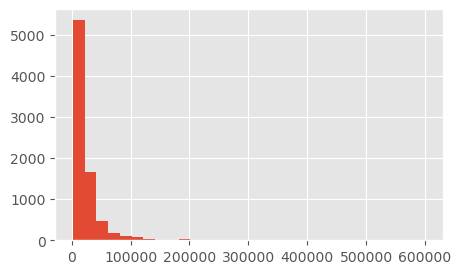

In [84]:
data['price'].hist(bins=30)
plt.show()

It's very skewed data, so let's use logarithm.

In [ ]:
data['price_log'] = np.log(data['price'])

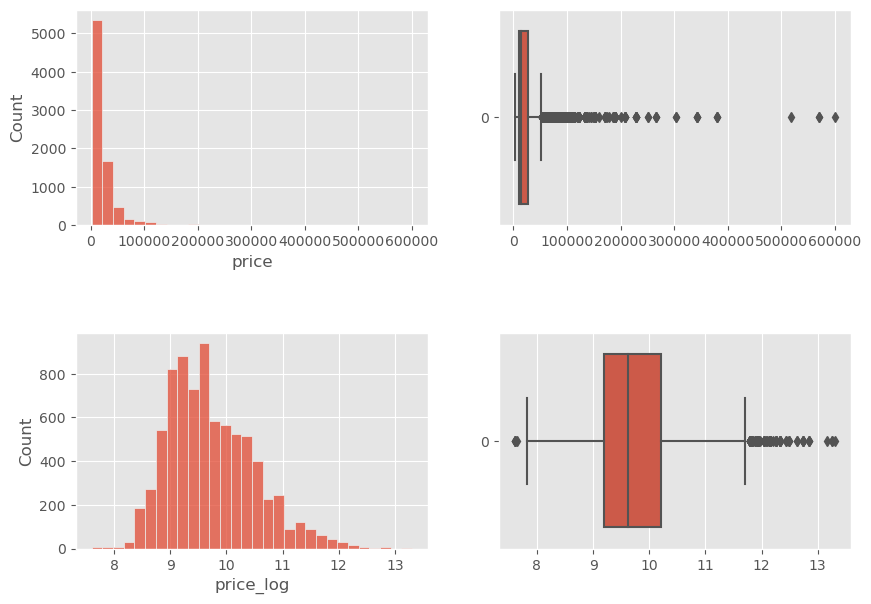

In [85]:
#plt.figure(figsize=(5, 7))
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
fig.subplots_adjust(hspace=.5)

sns.histplot(data['price'], ax=ax[0, 0], bins=30)
sns.boxplot(data['price'], ax=ax[0, 1], orient='h')

sns.histplot(data['price_log'], ax=ax[1, 0], bins=30)
sns.boxplot(data['price_log'], ax=ax[1, 1], orient='h')

plt.show()

### Baseline

metric: RMSE 

cross_validation: simple KFold

In [128]:
def get_train_test(df, log=False):
    X = df.drop(columns=['id', 'price', 'price_log'])
    if log:
        y = df['price_log']
    else:
        y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
    return X_train, X_test, y_train, y_test

In [133]:
X_train, X_test, y_train, y_test = get_train_test(data, log=False)

In [135]:
model = DummyRegressor(strategy='mean')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("MSE: ", mean_squared_error(y_test.values, y_pred, squared=False))

MSE:  30189.101501305406


In [136]:
model = DummyRegressor(strategy='median')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("MSE: ", mean_squared_error(y_test.values, y_pred, squared=False))

MSE:  31547.55607977089


In [141]:
X_train, X_test, y_train, y_test = get_train_test(data, log=True)

In [139]:
model = DummyRegressor(strategy='mean')

model.fit(X_train, y_train)
y_pred = np.exp(model.predict(X_test))
print("MSE: ", mean_squared_error(np.exp(y_test.values), y_pred, squared=False))

MSE:  31102.96614408686


In [142]:
model = DummyRegressor(strategy='median')

model.fit(X_train, y_train)
y_pred = np.exp(model.predict(X_test))
print("MSE: ", mean_squared_error(np.exp(y_test.values), y_pred, squared=False))

MSE:  31547.5560797709


In [149]:
feats = X_train.select_dtypes('number').columns
model = ExtraTreesRegressor(max_depth=7, random_state=24)


model.fit(X_train[feats], y_train)
y_pred = np.exp(model.predict(X_test[feats]))
print("MSE: ", mean_squared_error(np.exp(y_test.values), y_pred, squared=False))

MSE:  20632.951540770682


In [169]:
X_train, X_test, y_train, y_test = get_train_test(data, log=False)

num_rounds = 1_000

xgb_train = xgb.DMatrix(X_train[feats], y_train)

parameters = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=10)

[0]	train-rmse:35940.26476+884.95592	test-rmse:35984.25256+1884.92811
[10]	train-rmse:23837.53320+725.94431	test-rmse:24458.56083+2568.85741
[20]	train-rmse:20281.34124+559.95816	test-rmse:21615.93607+2016.83880
[30]	train-rmse:18764.58481+497.51813	test-rmse:21257.65994+1320.44248
[40]	train-rmse:18000.32001+502.26094	test-rmse:21106.53665+977.28688
[50]	train-rmse:17522.01495+530.12906	test-rmse:21222.06524+739.93808
[51]	train-rmse:17494.88465+526.31129	test-rmse:21290.75306+713.19939
